<a href="https://colab.research.google.com/github/nsiewick1/DS2002_MidtermProject/blob/main/DS2002_MidtermProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

API Keys:


- Source 1/API Call -> Link for documentation: https://api.covid19tracker.ca/docs/1.0/reports
- Source 2/CSV Local File -> CSV location: https://www.statista.com/statistics/481142/greenhouse-gas-emissions-in-canada-by-province/


**Data Ingestion** - Your pipeline must be capable of fetching and processing raw data
from two different sources:

o Source 1: A remote dataset retrieved via URL download or an API call.

o Source 2: A local file (CSV or JSON) mounted in your environment

In [ ]:
# Importing libraries
# Try to import all the libraries needed
try:
  import os
  import json
  import pprint
  import requests
  import requests.exceptions
  import pandas as pd
  import sqlite3
  import json
  import seaborn as sns
  import matplotlib.pyplot as plt
  import sqlite3



  print("Libraries imported successfully")
# If a library is missing
except ImportError as e:
  print(f"Error importing a library: {e}")
# If something else goes wrong
except Exception as e:
  print(f"Unexpected error during imports: {e}")

Libraries imported successfully


In [ ]:
# Loading in the CSV file and getting the first few rows
try:
  # Load the CSV file into a table (DataFrame)
  gas_emissions_canada = pd.read_csv("gas_emissions_canada.csv")
  # Show the data (you can also use .head() to see just the first few rows)
  gas_emissions_canada
# If the file is not found
except FileNotFoundError:
  print("Error: The file 'gas_emissions_canada.csv' was not found. Please check the filename and path")
# If the file is empty
except pd.errors.EmptyDataError:
  print("Error: The file is empty")
# If there is a problem reading the file
except pd.errors.ParserError:
  print("Error: The file could not be parsed. Please check the file format")
# For any other error
except Exception as e:
  print(f"An unexpected error occurred while loading the CSV file: {e}")


In [ ]:
# Create an empty DataFrame to store all the data
df1 = pd.DataFrame()

# Go through each province one by one
for each in ["AB", "ON", "QC", "SK", "BC", "MB", "NS", "NB", "NL", "PE", "NT", "YT", "NU"]:
    # Set up the API link for the current province
    url = "https://api.covid19tracker.ca/reports/province/" + each

    # Set the date to get data from
    query_params = {
        "date": "2022-10-31",  # Latest date in October 2022
    }

    try:
        # Send the request to the API
        covid_api = requests.get(url, params=query_params, timeout=10)
        covid_api.raise_for_status()  # Check for any error in the response

        # If there’s no useful data, skip this province
        if "data" not in covid_api.json() or not covid_api.json()["data"]:
            print(f"Warning: No 'data' found for province {each}")
            continue

        # Put the data into a temporary DataFrame
        temp_df = pd.DataFrame(covid_api.json()["data"])

        # Add the province name to the data
        temp_df["province"] = covid_api.json()["province"]

        # Add the data to the main DataFrame
        df1 = pd.concat([df1, temp_df], ignore_index=True)

    # Handle different kinds of possible errors
    except requests.exceptions.Timeout:
        print(f"Error: Request to {url} timed out")
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred for province {each}: {http_err}")
    except requests.exceptions.RequestException as req_err:
        print(f"Request problem for province {each}: {req_err}")
    except ValueError as ve:
        print(f"Problem decoding data for province {each}: {ve}")
    except Exception as e:
        print(f"Unexpected error for province {each}: {e}")

# Let the user know it's done
print("Data collection successfully completed")

# Save the last API response to a JSON file
try:
    with open('covid_api.json', 'w') as f:
        f.write(covid_api.text)
except IOError as e:
    print(f"An error occurred while saving the file: {e}")


Data collection successfully completed


In [ ]:
# Set the API URL to get info about Canadian provinces
url = "https://api.covid19tracker.ca/provinces"

try:
    # Send the API request
    province_data = requests.get(url, timeout=10)
    province_data.raise_for_status()  # Check if the response has an error

    # Let the user know it worked
    print("API response received successfully")

    # View the raw text data
    province_data.text

# Handle timeout error
except requests.exceptions.Timeout:
    print("Error: The request timed out")

# Handle HTTP errors (like 404 or 500)
except requests.exceptions.HTTPError as http_err:
    print(f"HTTP error occurred: {http_err}")

# Handle other request-related issues
except requests.exceptions.RequestException as req_err:
    print(f"Request failed: {req_err}")

# Catch any other unexpected errors
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Try to save the API response to a file
try:
    with open('province_data.json', 'w') as f:
        f.write(province_data.text)
except IOError as e:
    print(f"An error occurred: {e}")

# Convert the JSON data into a DataFrame for easy use
background = pd.DataFrame(province_data.json())


API response received successfully


**Data Transformation**: Your pipeline must support the following operations:
o Convert between file formats (e.g., JSON to CSV, CSV to JSON, JSON to SQL
database table, etc.). The user should be able to choose the desired output
format.

o Modify the dataset structure by adding or removing columns. If adding
columns, you may insert any additional useful information.

In [ ]:
import pandas as pd
import sqlite3

#function that changes the type of file
def transformations(data, from_type, to_type, file_path=None,
                    db_path="Covid_Data.db", table_name="Covid_Stats",
                    json_title = None, rearrange = False):
  #data is the original  file name, from_type is the type of the original file
  #(csv, json, and sql) to_type is the type of file you want to convert to (csv,
  # sql, or json), db_path is the database you are putting the data into (for sql),
  #table_name is the name of the table in the sql database,  json_title is used
  #when you need to rearrange the data before converting into a json, arrange is
  #a boolean value to know when a json file needs to be rearranged

    to_type = to_type.lower()
    from_type = from_type.lower()
    #lowers the types of file so that user input isnt case sensitive

    try:
        with sqlite3.connect(db_path) as conn: #connect to this sql database
            # Extract
            try:
                if from_type == 'csv':
                  #if its a csv, read it in and put into a data frame
                  df = pd.read_csv(data)
                elif from_type == 'json':
                  if rearrange == False:
                    #if its a json file and doesn't need to be rearranged,
                    #reads it into a data frame
                    df = pd.read_json(data)
                  else:
                    #if it does need to be rearranged, it uses the json_title
                    #to put it into a data frame
                    df = pd.DataFrame([pd.read_json(data)[json_title][0]])
                elif from_type == 'sql':
                    #selects all of the columns out of the sql database
                    #specified and puts it into a data frame
                    query = f"SELECT * FROM {table_name}"
                    df = pd.read_sql(query, conn)
                else:
                  #if it is not one of these types, raises an error
                    raise ValueError(f"Unsupported 'from_type': {from_type}")
            except FileNotFoundError:
                print(f"Error: File '{data}' not found.")
                return None
            except ValueError as ve:
                print(f"Value error: {ve}")
                return None
            except Exception as e:
                print(f"Error reading data from {from_type}: {e}")
                return None

            # Transform & Load
            try:
                if to_type == "json":
                    output_path = file_path if file_path else "Covid_Stats.json"
                    #outputs to a json file
                    df.to_json(output_path, orient="records", indent=2)
                    print(f"Data converted to JSON at: {output_path}")
                elif to_type == "csv":
                    output_path = file_path if file_path else "Covid_Stats.csv"
                    #outputs to a csv file
                    df.to_csv(output_path, index=False)
                    print(f"Data converted to CSV at: {output_path}")
                elif to_type == "sql":
                    df.to_sql(table_name, conn, if_exists="replace", index=False)
                    #outputs into a sql database
                    print(f"Data loaded into SQL table: {table_name}")
                else:
                  #if to_type isn't one of those specified, raises an error
                    raise ValueError(f"Unsupported 'to_type': {to_type}")
            except Exception as e:
                print(f"Error transforming/saving data to {to_type}: {e}")
                return None

            return df #returns the data frame

    except sqlite3.DatabaseError as db_err:
        print(f"Database connection error: {db_err}")
        return None
    except Exception as e:
        print(f"Unexpected error: {e}")
        return None


In [ ]:
# Ask user what file format they want to convert to
conn = sqlite3.connect("Covid_Data.db")
cursor = conn.cursor()

try:
    data_file = input('Which File Do You Want to Convert to? ').lower()

    # Convert the CSV file for carbon emissions to the chosen format
    transformations("gas_emissions_canada.csv", 'csv', data_file,
                    file_path="gas_emissions_canada." + data_file,
                    table_name='Carbon_Em')
except Exception as e:
    print(f"Error converting gas_emissions_canada.csv: {e}")

# Ask user for file format conversion details
try:
    data_file = input('Which File Do You Want to Convert to? ').lower()
    from_file = input('Which File Do You Want to Convert From? ').lower()

    if from_file == "json":
        # Convert JSON COVID file to CSV
        transformations("covid_api.json", 'json', data_file,
                        file_path='covid_api_' + from_file,
                        json_title='data', rearrange=True)
    elif from_file == 'csv':
        # Convert CSV COVID file to chosen format (e.g., SQL)
        transformations("covid_api_csv", 'csv', data_file,
                        file_path='covid_api_' + from_file,
                        table_name="Covid_Data")
    elif from_file == 'sql':
        # Convert SQL COVID file to chosen format (e.g., JSON)
        transformations("covid_api_sql", 'sql', data_file,
                        file_path='covid_api_' + from_file,
                        table_name="Covid_Data")
    else:
        print("Unsupported file type entered.")
except Exception as e:
    print(f"Error converting COVID file from {from_file}: {e}")

# Convert province data from JSON to selected format
try:
    data_file = input('Which File Do You Want to Convert to? ').lower()

    transformations("province_data.json", 'json', data_file,
                    file_path='province_data_csv.' + data_file,
                    table_name='Province_Data')
except Exception as e:
    print(f"Error converting province_data.json: {e}")


Which File Do You Want to Convert to? sql
Data loaded into SQL table: Carbon_Em
Which File Do You Want to Convert to? sql
Which File Do You Want to Convert From? json
Data loaded into SQL table: Covid_Stats
Which File Do You Want to Convert to? sql
Data loaded into SQL table: Province_Data


In [ ]:
try:
    # Keep only the important columns from the COVID data
    covid_df = df1[['total_cases', 'province', 'total_fatalities',
                    'total_recoveries', 'total_vaccinations']]

    # Keep only the important columns from the gas emissions data
    gas_emissions_canada2 = gas_emissions_canada[['2022', 'province', 'Full Name']]

    # Rename the columns to shorter, easier names
    gas_emissions_canada2.rename(columns={
        '2022': 'CO2_emissions',
        'Full Name': 'Full_Name'
    }, inplace=True)

    # Show the new emissions DataFrame
    gas_emissions_canada2

    # Let the user know it worked
    print("Data successfully subsetted and split")

# If anything goes wrong, print the error message
except Exception as e:
    print(f"Something went wrong while subsetting or splitting the data: {e}")


Data successfully subsetted and split


<ipython-input-63-7db3943379e0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gas_emissions_canada2.rename(columns={


In [ ]:
try:
    # List of columns we need from the data
    required_columns = {'gdp', 'population', 'code'}

    # Check if all required columns are in the data
    if not required_columns.issubset(background.columns):
        # If any column is missing, raise an error
        missing = required_columns - set(background.columns)
        raise KeyError(f"Missing columns in JSON data: {missing}")

    # Keep only the needed columns
    background_data = background[['gdp', 'population', 'code']]

    # Rename 'code' to 'province' to match other data
    background_data.rename(columns={'code': 'province'}, inplace=True)

    # Let the user know everything worked
    print("Background data prepared successfully")

    # Show the final background data
    background_data

# Handle JSON decoding errors
except ValueError as ve:
    print(f"Error decoding JSON: {ve}")

# Handle missing column errors
except KeyError as ke:
    print(f"Key error: {ke}")

# Handle any other unexpected errors
except Exception as e:
    print(f"An unexpected error occurred while preparing background data: {e}")


Background data prepared successfully


<ipython-input-65-efbbffc713d5>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  background_data.rename(columns={'code': 'province'}, inplace=True)


**Data Merging and Analysis**

Merge the two data sources into a single dataset.

*   Perform a simple data analysis (e.g., identifying correlations, trends, or
aggregations).
*   Present the analysis results in a structured format (tables, charts, or summary
statistics).

In [ ]:
try:
    # Merge the emissions data and COVID data using the 'province' column
    merged_df = pd.merge(gas_emissions_canada2, covid_df, on='province')

    # Let the user know the merge worked
    print("Dataframes merged successfully")

    # Show the merged data
    merged_df

# If the key column ('province') is missing from either DataFrame
except KeyError as e:
    print(f"Error: Merge failed due to missing key column: {e}")

# If something goes wrong during the merge
except pd.errors.MergeError as e:
    print(f"Merge error: {e}")

# Catch any other unexpected errors
except Exception as e:
    print(f"An unexpected error occurred during the merge: {e}")


Dataframes merged successfully


In [ ]:
try:
    # Merge the previous merged data with the background data using 'province'
    subsetted_data = pd.merge(merged_df, background_data, on='province')

    # Let the user know the final merge worked
    print("Final merge successful.")

    # Show the merged result (you can also use .head() to preview a few rows)
    subsetted_data

# If 'province' is missing in either DataFrame
except KeyError as e:
    print(f"Merge failed: Missing 'province' key in one of the DataFrames - {e}")

# If there’s a general merge error
except pd.errors.MergeError as me:
    print(f"Merge error occurred: {me}")

# Catch any other unexpected problems
except Exception as e:
    print(f"An unexpected error occurred during final merge: {e}")


Final merge successful. Preview of full data:


In [ ]:
try:
  #takes subsets of the large data frame
  health_df = subsetted_data[["province", "total_cases", "total_fatalities", "total_recoveries", "total_vaccinations"]]
  econ_df = subsetted_data[["province", "Full_Name", "CO2_emissions", "gdp", "population"]]
# Throws an error message for any exceptions/errors
except Exception as e:
    print(f"Something went wrong while subsetting or splitting the data: {e}")

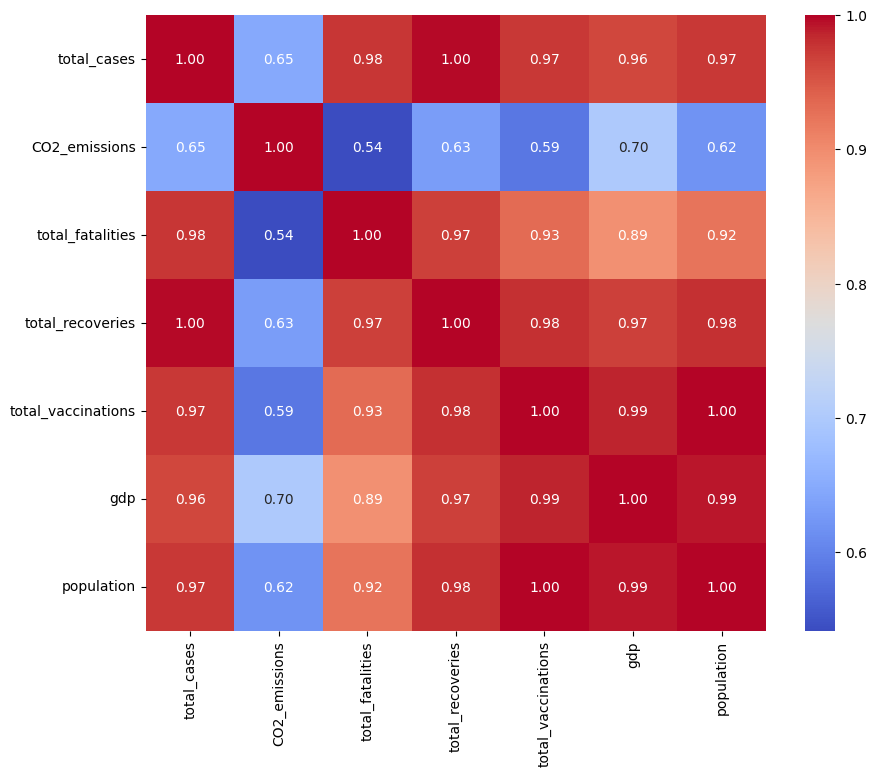

In [ ]:
#gets rid of the categorical variables for the correlation matrix
cor_subsets = subsetted_data[['total_cases', 'CO2_emissions', 'total_fatalities',
                             'total_recoveries', 'total_vaccinations', 'gdp',
                             'population']]
#gets the correlaiton values
cor_matrix = cor_subsets.corr()

plt.figure(figsize=(10, 8))
#creates a heatmap with the correlation matrix
sns.heatmap(cor_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

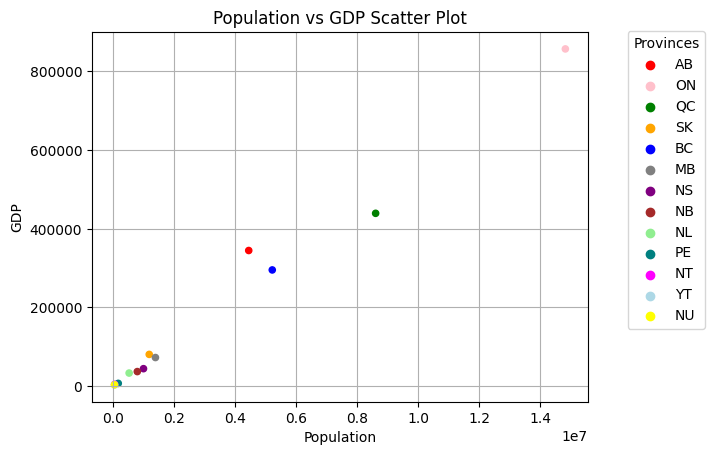

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

try:
    # Set up a list of colors for the provinces
    color_palette = ["red", "pink", "green", "orange", "blue", "gray",
                     "purple", "brown", "lightgreen", "teal", "magenta",
                     "lightblue", "yellow"]

    # Add a new column 'color' to match each province with a color
    subsetted_data['color'] = color_palette[:len(subsetted_data)]

    # Create a scatter plot of population vs GDP using the assigned colors
    subsetted_data.plot.scatter(x='population', y='gdp', color=color_palette)

    # Add a custom legend with province names and their colors
    for province, color in zip(subsetted_data['province'], subsetted_data['color']):
        plt.scatter([], [], color=color, label=province)
    plt.legend(title="Provinces", bbox_to_anchor=(1.25, 0.6), loc="center right")
    plt.title('Population vs GDP Scatter Plot')
    plt.xlabel('Population')
    plt.ylabel('GDP')
    plt.grid(True)
    plt.show()

# If anything goes wrong while plotting
except Exception as e:
    print("Something went wrong while creating the scatter plot")


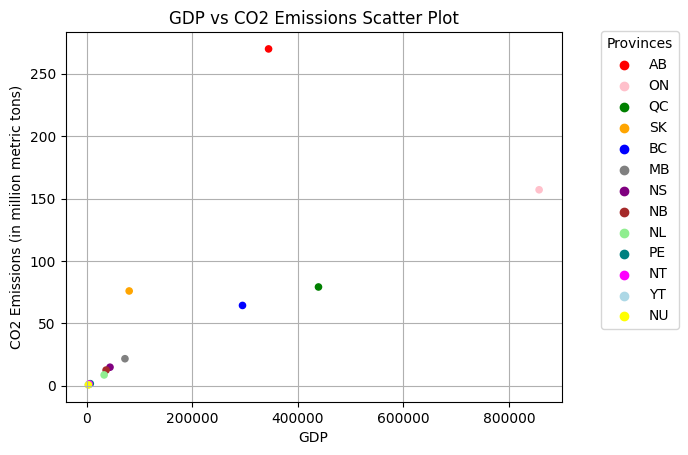

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

try:
    # Assign colors to each province
    color_palette = ["red", "pink", "green", "orange", "blue", "gray",
                     "purple", "brown", "lightgreen", "teal", "magenta",
                     "lightblue", "yellow"]
    subsetted_data['color'] = color_palette[:len(subsetted_data)]

    # Create scatter plot of GDP vs CO2 emissions
    subsetted_data.plot.scatter(x='gdp', y='CO2_emissions', color=color_palette)

    # Add custom legend
    for province, color in zip(subsetted_data['province'], subsetted_data['color']):
        plt.scatter([], [], color=color, label=province)
    plt.legend(title="Provinces", bbox_to_anchor=(1.25, 0.6), loc="center right")

    # Add labels and title
    plt.title('GDP vs CO2 Emissions Scatter Plot')
    plt.xlabel('GDP')
    plt.ylabel('CO2 Emissions (in million metric tons)')
    plt.grid(True)
    plt.show()

except Exception:
    print("Something went wrong while creating the GDP vs CO2 emissions scatter plot")


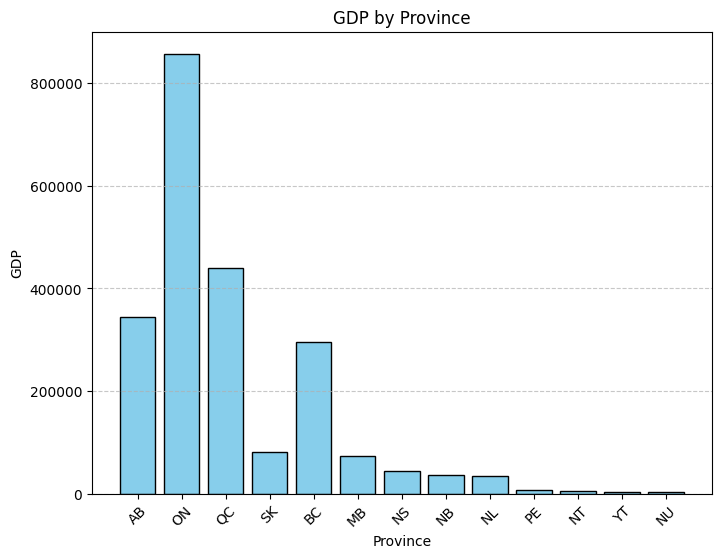

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

try:
  plt.figure(figsize=(8, 6))
  #creates a bar graph between province and gdp where the color is blue and the
  #outline is black
  plt.bar(subsetted_data['province'], subsetted_data['gdp'], color='skyblue', edgecolor='black')

  plt.xlabel('Province') #creates an x-axis label
  plt.ylabel('GDP') #creates a y-axis label
  plt.title('GDP by Province') #creates a title
  plt.xticks(rotation=45) #changes the x-axis tick marks
  plt.grid(axis='y', linestyle='--', alpha=0.7) #changes the line markers
  plt.show() #shwos the graph

except Exception:
    print("Something went wrong while creating the GDP bar chart")

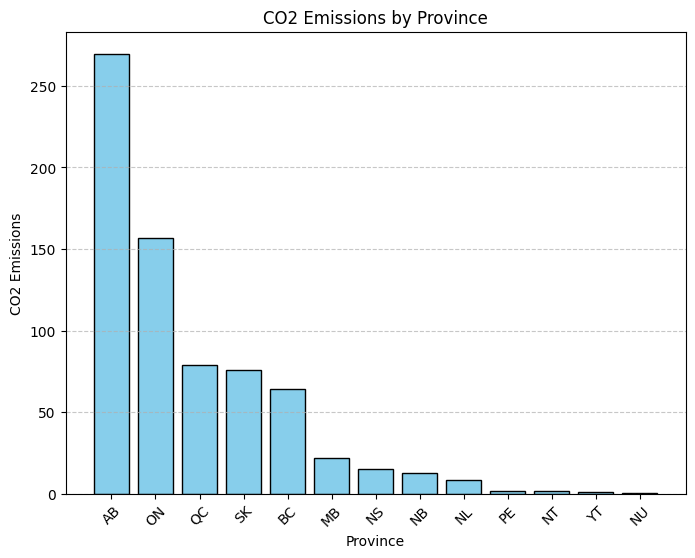

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Set the size of the plot
plt.figure(figsize=(8, 6))

# Create a bar chart showing CO2 emissions by province
plt.bar(subsetted_data['province'], subsetted_data['CO2_emissions'],
        color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Province')
plt.ylabel('CO2 Emissions')
plt.title('CO2 Emissions by Province')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add horizontal grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


In [ ]:
# Adds "recovered_percentage" column to subsetted dataframe
subsetted_data['recovered_percentage'] = (subsetted_data['total_recoveries'] / subsetted_data['total_cases']) * 100

# Display the updated DataFrame
print(subsetted_data[['province', 'recovered_percentage']])

   province  recovered_percentage
0        AB             85.471680
1        ON             97.920599
2        QC             89.519470
3        SK             80.019116
4        BC             79.484374
5        MB             85.473734
6        NS             40.522617
7        NB             92.335389
8        NL             54.612146
9        PE             95.587076
10       NT             99.133555
11       YT             98.724434
12       NU             97.281223


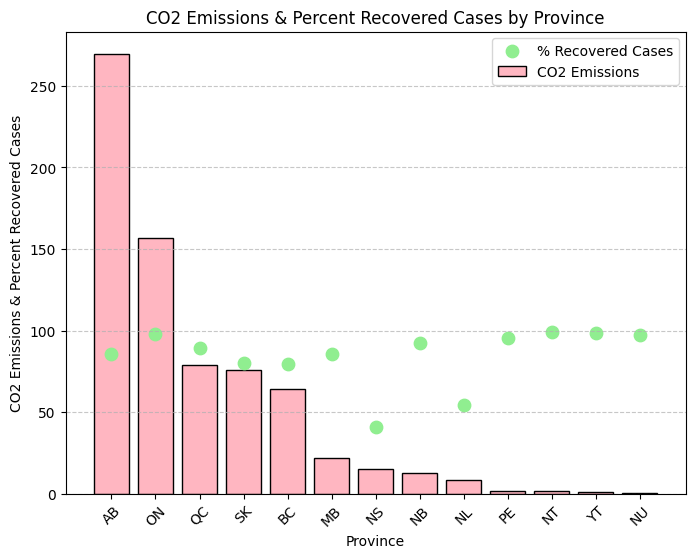

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Bar chart
plt.bar(subsetted_data['province'], subsetted_data['CO2_emissions'], color='lightpink', edgecolor='black', label='CO2 Emissions')

# Scatter plot (adjust y-values slightly for better visibility)
plt.scatter(subsetted_data['province'], subsetted_data['recovered_percentage'], color='lightgreen', marker='o', s=80, label='% Recovered Cases')

# Labels and formatting
plt.xlabel('Province')
plt.ylabel('CO2 Emissions & Percent Recovered Cases')
plt.title('CO2 Emissions & Percent Recovered Cases by Province')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.show()


**Data Storage:**

*   Save the transformed data as a SQL database. Create required table
inserts...etc. You can use sqlite or mysql.

In [ ]:
# Data Storage using SQLite

import sqlite3

try:
    # Connect to database
    conn = sqlite3.connect("Covid_Data.db")
    cursor = conn.cursor()
    print("Connected to the database successfully")

    # Create tables
    create_health_table = """
    CREATE TABLE IF NOT EXISTS Covid_Health_Stats(
      province TEXT PRIMARY KEY,
      total_cases INTEGER,
      total_fatalities INTEGER,
      total_recoveries INTEGER,
      total_vaccinations INTEGER
    );
    """

    create_econ_table = """
    CREATE TABLE IF NOT EXISTS Province_Econ_Stats(
      province TEXT PRIMARY KEY,
      full_name TEXT,
      CO2_emissions REAL,
      gdp REAL,
      population INTEGER
    );
    """

    cursor.execute(create_health_table)
    cursor.execute(create_econ_table)
    conn.commit()
    print("Tables created successfully.")

    # Insert data
    health_df.to_sql("Covid_Health_Stats", conn, if_exists="replace", index=False)
    econ_df.to_sql("Province_Econ_Stats", conn, if_exists="replace", index=False)
    print("Data inserted into both tables successfully.")

    # Query 1: Top 5 provinces by case count
    try:
        query = """
        SELECT province, total_cases
        FROM Covid_Health_Stats
        ORDER BY total_cases DESC
        LIMIT 5;
        """
        result = cursor.execute(query).fetchall()
        print("Top 5 provinces by COVID case count:", result)
    except Exception as e:
        print("Error in top 5 COVID case count query:", e)

    # Query 2: Low vaccination, high fatalities
    try:
        query1 = """
        SELECT province, total_vaccinations, total_fatalities
        FROM Covid_Health_Stats
        WHERE total_vaccinations < 1000000
        ORDER BY total_fatalities DESC;
        """
        result1 = cursor.execute(query1).fetchall()
        print("Provinces with low vaccination rates and high fatalities:", result1)
    except Exception as e:
        print("Error in low vaccination / high fatality query:", e)

    # Query 3: GDP and CO2 emissions
    try:
        query2 = """
        SELECT province, gdp, CO2_emissions
        FROM Province_Econ_Stats
        ORDER BY gdp DESC;
        """
        result2 = cursor.execute(query2).fetchall()
        print("Correlation between GDP and CO2 emissions:", result2)
    except Exception as e:
        print("Error in GDP vs CO2 emissions query:", e)

    # Query 4: Cases per capita
    try:
        query3 = """
        SELECT h.province, h.total_cases, e.population,
          CAST(h.total_cases AS FLOAT) / e.population AS cases_per_capita
        FROM Covid_Health_Stats h
        JOIN Province_Econ_Stats e ON h.province = e.province
        ORDER BY cases_per_capita DESC;
        """
        result3 = cursor.execute(query3).fetchall()
        print("COVID cases per capita:", result3)
    except Exception as e:
        print("Error in COVID cases per capita query:", e)

    # Summary of record counts
    try:
        num_health_records = cursor.execute("SELECT COUNT(*) FROM Covid_Health_Stats").fetchone()[0]
        num_econ_records = cursor.execute("SELECT COUNT(*) FROM Province_Econ_Stats").fetchone()[0]
        print(f"Covid_Health_Stats: {num_health_records} records")
        print(f"Province_Econ_Stats: {num_econ_records} records\n")
    except Exception as e:
        print("Error summarizing table records:", e)

except Exception as main_error:
    print(f"An unexpected error occurred during database operations: {main_error}")

finally:
    # Close database connection
    try:
        conn.close()
        print("Database connection closed.")
    except Exception as close_error:
        print(f"Error closing the database connection: {close_error}")


Connected to the database successfully
Tables created successfully.
Data inserted into both tables successfully.
Top 5 provinces by COVID case count: [('ON', 1494373), ('QC', 1227810), ('AB', 612693), ('BC', 387451), ('MB', 151319)]
Provinces with low vaccination rates and high fatalities: [('PE', 391227, 46), ('YT', 92743, 26), ('NT', 102863, 22), ('NU', 77083, 7)]
Correlation between GDP and CO2 emissions: [('ON', 857384.0, 157.0), ('QC', 439375.0, 79.1), ('AB', 344812.0, 269.9), ('BC', 295401.0, 64.3), ('SK', 80679.0, 75.9), ('MB', 72688.0, 21.6), ('NS', 44354.0, 14.8), ('NB', 36966.0, 12.5), ('NL', 33241.0, 8.6), ('PE', 6994.0, 1.6), ('NT', 4730.0, 1.4), ('NU', 3421.0, 0.6), ('YT', 3046.0, 0.7)]
COVID cases per capita: [('PE', 43146, 164318.0, 0.2625762241507321), ('NT', 11426, 45504.0, 0.2510988045007032), ('QC', 1227810, 8604495.0, 0.14269402213610444), ('AB', 612693, 4442879.0, 0.13790449841195315), ('SK', 141245, 1179844.0, 0.11971497926844565), ('MB', 151319, 1383765.0, 0.1093

**Data Summarization:**

Your code should generate a brief summary of the ingested data, including:

*   Number of records

*   Number of columns


After processing, your code should generate a summary of the transformed
data, including:

*   Number of records

*   Number of columns


In [ ]:
#Summary of Ingested Data

try:
  # Check if the DataFrame exists and is not empty
  if 'gas_emissions_canada' in locals() and not gas_emissions_canada.empty:
    print("\nFull data summary of carbon emissions data from the CSV:")
    print(gas_emissions_canada.describe())

    print("\nFull data shape:")
    print(f"Number of rows: {gas_emissions_canada.shape[0]}")
    print(f"Number of columns: {gas_emissions_canada.shape[1]}")

  if 'df1' in locals() and not df1.empty:
    print("\nFull data summary of COVID data from the API:")
    print(df1.describe())

    print("\nFull data shape:")
    print(f"Number of rows: {df1.shape[0]}")
    print(f"Number of columns: {df1.shape[1]}")

  if 'background' in locals() and not background.empty:
    print("\nFull data summary for province data from the API:")
    print(background.describe())

    print("\nFull data shape:")
    print(f"Number of rows: {background.shape[0]}")
    print(f"Number of columns: {background.shape[1]}")

# Error handling with the excepts...specific error messages gets printed
  else:
    print("Warning: DataFrame is empty or undefined.")
except NameError:
    print("Error: DataFrame not defined. Make sure the merge was successful.")
except Exception as e:
    print(f"An unexpected error occurred while describing the DataFrame: {e}")



Full data summary of carbon emissions data from the CSV:
             2005        2022
count   13.000000   13.000000
mean    58.576923   54.461538
std     81.062889   79.587232
min      0.600000    0.600000
25%      1.900000    1.600000
50%     20.600000   14.800000
75%     80.500000   75.900000
max    251.100000  269.900000

Full data shape:
Number of rows: 13
Number of columns: 5

Full data summary of COVID data from the API:
       change_cases  change_fatalities  change_tests  change_hospitalizations  \
count     13.000000          13.000000     13.000000                13.000000   
mean     197.000000           1.153846    404.615385                 4.769231   
std      550.318393           4.160251   1458.861516                17.195706   
min        0.000000           0.000000      0.000000                 0.000000   
25%        0.000000           0.000000      0.000000                 0.000000   
50%        0.000000           0.000000      0.000000                 0.000000   


In [ ]:
# Summary of all transformed DataFrames

try:
    # Summary for merged dataset
    print("Subsetted Data Summary:")
    print(subsetted_data.describe())
    print(f"Shape: {subsetted_data.shape}\n")
except Exception as e:
    print(f"Error with subsetted_data: {e}")

try:
    # Summary for health data
    print("Health Data Summary:")
    print(health_df.describe())
    print(f"Shape: {health_df.shape}\n")
except Exception as e:
    print(f"Error with health_df: {e}")

try:
    # Summary for economic data
    print("Economic Data Summary:")
    print(econ_df.describe())
    print(f"Shape: {econ_df.shape}\n")
except Exception as e:
    print(f"Error with econ_df: {e}")


Subsetted Data Summary:
       CO2_emissions   total_cases  total_fatalities  total_recoveries  \
count      13.000000  1.300000e+01         13.000000      1.300000e+01   
mean       54.461538  3.307937e+05       3545.769231      2.946340e+05   
std        79.587232  4.921808e+05       5735.431881      4.679726e+05   
min         0.600000  3.531000e+03          7.000000      3.435000e+03   
25%         1.600000  4.314600e+04         46.000000      2.516200e+04   
50%        14.800000  1.061580e+05        451.000000      6.513800e+04   
75%        75.900000  3.874510e+05       4485.000000      3.079630e+05   
max       269.900000  1.494373e+06      16947.000000      1.463299e+06   

       total_vaccinations            gdp    population  recovered_percentage  
count        1.300000e+01      13.000000  1.300000e+01             13.000000  
mean         7.131771e+06  171007.000000  2.942008e+06             84.314263  
std          1.095483e+07  253389.407306  4.411029e+06             17.89